In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn


class MLP(nn.Module):

    def __init__(self, n_inputs, n_hidden, n_classes):
        """
        Initializes multi-layer perceptron object.
        Args:
            n_inputs: number of inputs (i.e., dimension of an input vector).
            n_hidden: list of integers, where each integer is the number of units in each linear layer
            n_classes: number of classes of the classification problem (i.e., output dimension of the network)
        """

        super(MLP, self).__init__()
        layers = []

        # input layer
        layers.append(nn.Linear(n_inputs, n_hidden[0]))
        layers.append(nn.Sigmoid())

        for i in range(1, len(n_hidden)):
            layers.append(nn.Linear(n_hidden[i - 1], n_hidden[i]))
            layers.append(nn.Sigmoid())

        # output layer
        layers.append(nn.Linear(n_hidden[-1], n_classes))

        # Generate model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Predict network output from input by passing it through several layers.
        Args:
            x: input to the network
        Returns:
            out: output of the network
        """

        out = self.model(x)
        return out


2.5.1+cu124
torch.cude.is_avaiableTrue
device:cuda
训练数据的形状: (50000, 3072)
训练标签的形状: (50000,)
train_data_tensor:tensor([[0.2314, 0.1686, 0.1961,  ..., 0.5490, 0.3294, 0.2824],
        [0.6039, 0.4941, 0.4118,  ..., 0.5451, 0.5569, 0.5647],
        [1.0000, 0.9922, 0.9922,  ..., 0.3255, 0.3255, 0.3294],
        ...,
        [0.1373, 0.1569, 0.1647,  ..., 0.3020, 0.2588, 0.1961],
        [0.7412, 0.7294, 0.7255,  ..., 0.6627, 0.6706, 0.6706],
        [0.8980, 0.9255, 0.9176,  ..., 0.6784, 0.6353, 0.6314]],
       device='cuda:0')
train_label_tensor:tensor([6, 9, 9,  ..., 9, 1, 1], device='cuda:0')
Epoch [10/500], Loss: 1.6959, Train Accuracy: 40.98%, Test Accuracy: 40.70%
Epoch [20/500], Loss: 1.6001, Train Accuracy: 44.18%, Test Accuracy: 43.03%
Epoch [30/500], Loss: 1.4500, Train Accuracy: 46.77%, Test Accuracy: 45.69%
Epoch [40/500], Loss: 1.4925, Train Accuracy: 48.70%, Test Accuracy: 47.44%
Epoch [50/500], Loss: 1.4343, Train Accuracy: 49.57%, Test Accuracy: 47.43%
Epoch [60/500], Los

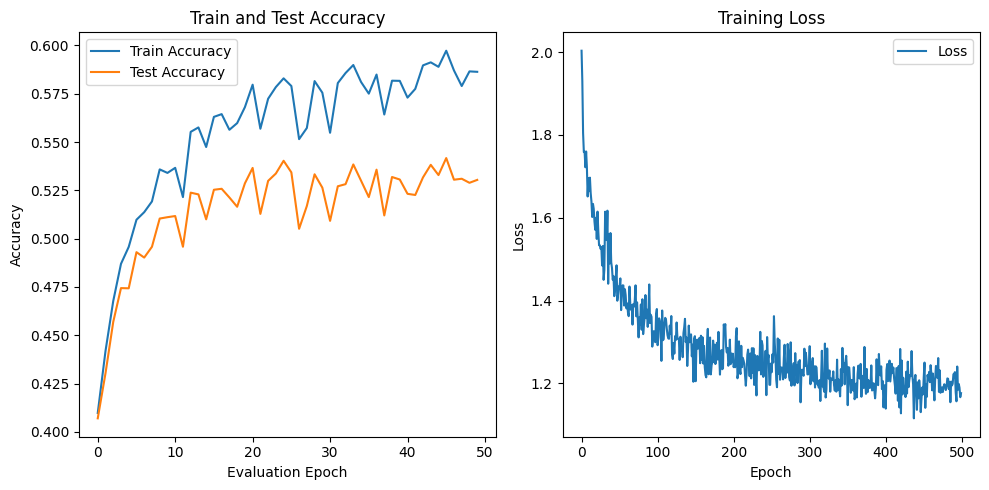

In [3]:
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
from pytorch_mlp import MLP
import argparse
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

DNN_HIDDEN_UNITS_DEFAULT = "200, 300"
LEARNING_RATE_DEFAULT = 0.001
MAX_EPOCHS_DEFAULT = 500
EVAL_FREQ_DEFAULT = 10
DECAY = 0.001

FLAGS = None


def unpickle(file):
    import pickle

    with open("data/cifar-10-batches-py/" + file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

def load_cifar10_data():
    data_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    
    all_data = []
    all_labels = []
    
    # load all data
    for file in data_files:
        data_dict = unpickle(file)
        all_data.append(data_dict[b'data'])
        all_labels.append(data_dict[b'labels'])
    
    all_data = np.vstack(all_data)  # 合并所有数据
    all_labels = np.concatenate(all_labels)  # 合并所有标签

    return all_data, all_labels

def get_train_test_data(test_file):
    train_data, train_label = load_cifar10_data()

    print(f"训练数据的形状: {train_data.shape}")
    print(f"训练标签的形状: {train_label.shape}")

    test_data_batch = unpickle(test_file)

    test_data = test_data_batch[b"data"]
    test_label = test_data_batch[b"labels"]

    # 把字典的值转成array格式，方便操作
    train_data = np.array(train_data)
    # print(f"train_data:{train_data.shape},{train_label}")
    train_label = np.array(train_label)
    # print(f"train_label:{train_label.shape},{train_label}")

    test_data = np.array(test_data)
    # print(f"test_data:{test_data.shape},{test_data}")
    test_label = np.array(test_label)
    # print(f"test_label:{test_label.shape},{test_label}")
    return train_data, train_label, test_data, test_label


def tensor_tranfer(train_data, train_label, test_data, test_label, device):
    # Convert training and testing data to PyTorch tensors
    train_data_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)
    train_label_tensor = torch.tensor(train_label, dtype=torch.long).to(
        device
    )  # Convert to class indices
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).to(device)
    test_label_tensor = torch.tensor(test_label, dtype=torch.long).to(device)
    return (
        train_data_tensor / 255,
        train_label_tensor,
        test_data_tensor / 255,
        test_label_tensor,
    )


def calculate_accuracy(output, target):
    # 输出为 logits
    predicted = torch.argmax(output, dim=1)
    # 检查预测是否正确
    correct = (predicted == target).sum().item()
    # 计算准确率
    accuracy = correct / target.size(0)
    return accuracy


# # 定义数据转换（如归一化）
# transform = transforms.Compose(
#     [
#         transforms.ToTensor(),  # 转换为 PyTorch 张量
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 归一化
#     ]
# )

# # 加载 CIFAR-10 数据集
# train_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
# test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)


def train():

    test_file = "test_batch"

    print(f"torch.cude.is_avaiable{torch.cuda.is_available()}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"device:{device}")

    train_data, train_label, test_data, test_label = get_train_test_data(test_file)

    train_data_tensor, train_label_tensor, test_data_tensor, test_label_tensor = (
        tensor_tranfer(train_data, train_label, test_data, test_label, device)
    )

    print(f"train_data_tensor:{train_data_tensor}")
    print(f"train_label_tensor:{train_label_tensor}")

    dnn_hidden_units = list(map(int, FLAGS.dnn_hidden_units.split(",")))
    # print(f"dnn_hidden_units are :{dnn_hidden_units}")

    # print(f"train_label.shape:{train_label}")
    # print(f"train_data.shape[1]: {train_data.shape[1]}")

    model = MLP(train_data.shape[1], dnn_hidden_units, 10)
    model.to(device)
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE_DEFAULT, weight_decay=DECAY)

    BATCH_SIZE = 1000
    # Initialize lists to store metrics
    train_accuracies = []
    test_accuracies = []
    losses = []

    # 创建 TensorDataset 和 DataLoader
    train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    for epoch in range(FLAGS.max_steps):
        model.train()  # Set model to training mode

        for X_batch, y_batch in train_loader:
            # print(f"about y_barch:{y_batch.shape}, {y_batch}")
            optimizer.zero_grad()  # Clear gradients
            outputs = model(X_batch)  # Forward pass

            # Check the shape of y_train_tensor
            # print(f"y_train_tensor shape: {y_train_tensor.shape}")
            final_loss = loss(outputs, y_batch)  # Calculate loss
            # print(f"first_final_loss:{final_loss.item():.4f}")
            final_loss.backward()  # Backward pass
            optimizer.step()  # Update weights
        
        # Record the last batch loss for this epoch
        losses.append(final_loss.item())

        if (epoch + 1) % FLAGS.eval_freq == 0:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                train_predictions = model(train_data_tensor)
                test_predictions = model(test_data_tensor)

                # print(f"train_prediction:{train_predictions.shape},{train_predictions}")

                # Compute accuracy
                train_accuracy = calculate_accuracy(
                    train_predictions.to(device), train_label_tensor.to(device)
                )
                test_accuracy = calculate_accuracy(
                    test_predictions.to(device), test_label_tensor.to(device)
                )
                
                # Record accuracy
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)
                
                print(
                    f"Epoch [{epoch + 1}/{FLAGS.max_steps}], "
                    f"Loss: {final_loss.item():.4f}, "
                    f"Train Accuracy: {train_accuracy * 100:.2f}%, "
                    f"Test Accuracy: {test_accuracy * 100:.2f}%"
                )
    # Plot accuracy and loss
    plt.figure(figsize=(10, 5))

    # Plot training and test accuracy
    plt.subplot(1, 2, 1)
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
    plt.xlabel('Evaluation Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(range(len(losses)), losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Save the plot
    plt.tight_layout()
    plt.savefig('accuracy_loss_plot.png')  # Save to local file
    print("Plot saved as accuracy_loss_plot.png")
    plt.show()


if __name__ == "__main__":
    # Command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--dnn_hidden_units",
        type=str,
        default=DNN_HIDDEN_UNITS_DEFAULT,
        help="Comma separated list of number of units in each hidden layer",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=LEARNING_RATE_DEFAULT,
        help="Learning rate",
    )
    parser.add_argument(
        "--max_steps",
        type=int,
        default=MAX_EPOCHS_DEFAULT,
        help="Number of epochs to run trainer.",
    )
    parser.add_argument(
        "--eval_freq",
        type=int,
        default=EVAL_FREQ_DEFAULT,
        help="Frequency of evaluation on the test set",
    )
    FLAGS, unparsed = parser.parse_known_args()

    print(torch.__version__)
    train()
